# Previsão de volatilidade

### INTRODUÇÃO

Na teoria financeira, a incerteza é um fator bastante importante. O risco que quantifica a incerteza, em geral, está associado à variância dos retornos ou ao desvio padrão, que pode ser definido como volatilidade. 

Exitem diversos modelos que buscam, de alguma maneira, captar a volatilidade de séries financeiras. Aqui nesse trabalho, buscaremos, através de uma metodologia híbrida, utilizar parâmetros de volatilidade de modelos cássicos, como os famosos modelos da fámilia GARCH, com o poder de uma rede neural GRU para fazer a previsão da volatilidade, três passos à frente, da série de preços do barril de petróleo.





---



### PACOTES

In [ ]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
!pip install Quandl
import quandl #dados financeiros
import matplotlib.pyplot as plt
from pandas import concat
# arch
!pip install arch
from arch import arch_model # ARCH, GARCH
import math 
from numpy.linalg import LinAlgError
from scipy import stats

from sklearn.preprocessing import MinMaxScaler

# lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import concatenate



     |████████████████████████████████| 899 kB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 26.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


### Base de dados: 
1) Trabalharemos com preços diários do barril de óleo (OPEC Crude Oil Price - Nasdaq).\
2) Calcularemos os retornos logarítmicos para cálculo da volatilidade (semanal).\
3) Calcularemos volatilidade condicional através do modelo EGARCH.\
4) Calcularemos os resíduos do modelo EGARCH.\
5) Agregaremos tudo a uma única base de dados.

In [ ]:
#base de dados
#preços OPEC Crude Oil Price - Nasdaq
df = quandl.get("OPEC/ORB", start_date="2007-01-01", end_date="2021-10-01", index_col='Date')

In [ ]:
# para estimar da volatilidade, precisamos calcular o retorno logaritmico do ativo
df['retorno'] = np.log(df['Value'] / df['Value'].shift(1))
df = df.dropna()

In [ ]:
# calculando a volatilidade (janela movel 5 dias - semanal) baseada no log retorno
df['vola'] = df['retorno'].rolling(window=5).std()
df = df.dropna()

##### Cálculo da Volatilidade Condicional - modelo Egarch

In [ ]:
# Modelo eGARCH (1,1) para capturar a volatilidade condicional e os resíduos
am = arch_model(df['retorno'], x=None, mean='zero', lags=0, vol='eGarch', p=1, o=1, q=1, power=0, dist='SkewStudent', hold_back=None, rescale=None)
res = am.fit(update_freq=4)
#garch = res.conditional_volatility * math.sqrt(5) # semanal
#garch = res.conditional_volatility * math.sqrt(252) # anual
#garch = garch.rename("egarch_cond_vola")
print(res.summary())

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004637. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


Iteration:      4,   Func. Count:     46,   Neg. LLF: -10634.38866179481
Iteration:      8,   Func. Count:     84,   Neg. LLF: -10646.05380615875
Iteration:     12,   Func. Count:    117,   Neg. LLF: -10647.551180043756
Iteration:     16,   Func. Count:    149,   Neg. LLF: -10647.556176325339
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -10647.556176325294
            Iterations: 16
            Function evaluations: 149
            Gradient evaluations: 16
                             Zero Mean - EGARCH Model Results                            
Dep. Variable:                           retorno   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:                10647.6
Distribution:      Standardized Skew Student's t   AIC:                          -21283.1
Method:                       Maximum Likel

O objetivo do trabalho não é fitar o melhor modelo clássico, inclusive, como observação, o pacote Rugarch (em R) apresenta mais aderência à literatura para a formulação desses modelos. O objetivo do presente trabalho é desenvolver um modelo "híbrido" para previsão da voltatilidade. 

No entanto, para a escolha do modelo foram feitos alguns modelos, com algumas séries de distribuição, sendo que o melhor deles, de acordo com os critérios AIC e BIC, foi o EGARCH(1,1) com distribuição Skew Student. 

Podemos verificar que todos os parâmetros do modelo são estatisticamente significativos.

In [ ]:
# criando vetores
vola_cond = res.conditional_volatility # volatilidade condicional
std_res = res.std_resid # resíduos

In [ ]:
# adicionando à base
df['vola_cond'] = vola_cond
df['std_res'] = std_res

df = df[['Value', 'retorno' , 'vola_cond', 'std_res', 'vola']] #reordenando

### EDA

Aqui faremos uma análise exploratória dos dados

In [ ]:
# visualização da base
df.head()

,Value,retorno,vola_cond,std_res,vola
Date,,,,,
2007-01-09,51.20,-0.013194,0.015738,-0.838349,0.020933
2007-01-10,50.60,-0.011788,0.016152,-0.729804,0.021035
2007-01-11,49.22,-0.027652,0.016402,-1.685860,0.018475
2007-01-12,48.68,-0.011032,0.018250,-0.604484,0.013929
2007-01-15,49.36,0.013872,0.018290,0.758457,0.014966


In [ ]:
df.describe()

,Value,retorno,vola_cond,std_res,vola
count,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000
mean,73.847945,0.000102,0.016902,0.017348,0.014796
std,25.719905,0.021536,0.011087,1.006670,0.014682
min,12.220000,-0.331150,0.005283,-10.894807,0.000697
25%,53.307500,-0.008313,0.011333,-0.575127,0.007650
50%,69.925000,0.000665,0.014466,0.044907,0.011770
75%,100.395000,0.009034,0.019097,0.641132,0.016978
max,140.730000,0.228699,0.108513,5.743310,0.195197


Verificamos o comportamento da série de preços do barril de óleo em US\$. A série é composta por 3800 amostras de preços diários compreendidas entre 09/01/2007 à 01/10/2021. De acordo com as descrições estatísticas da série, a média de preços do período é de US\$ 73.84, com um desvio padrão de $ 25.71, um mínimo de US\$ 12.22 e um máximo de US\$ 140.73. 

Podemos verificar a série de retornos logarítimicos que será utilizada para o cáculo da volatilidade. A média dos retornos no período tende a zero, com um desvio padrão de 0.02, um mmínimo de -0.33 e um máximo de 0.23.

<Figure size 432x288 with 0 Axes>

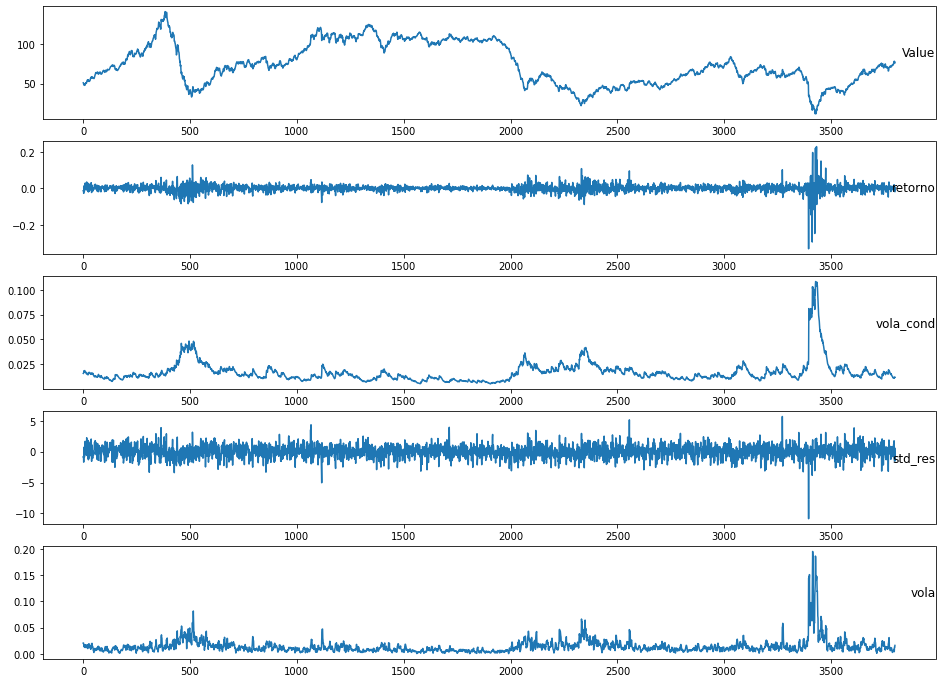

In [ ]:
# visualização gráfica das séries
dataset = df
values = dataset.values
# especificando colunas
groups = [0, 1, 2, 3, 4]
i = 1
# plot cada coluna
plt.figure()
plt.subplots(figsize=(16, 12))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

Gráficamente podemos verificar a série de preços (Value), 1º gráfico, a série de retornos, 2º gráfico, a volatilidade condicional no terceiro gráfico, seguido dos resíduos do modelo de volatilidade com a volatilidade semanal no último gráfico.

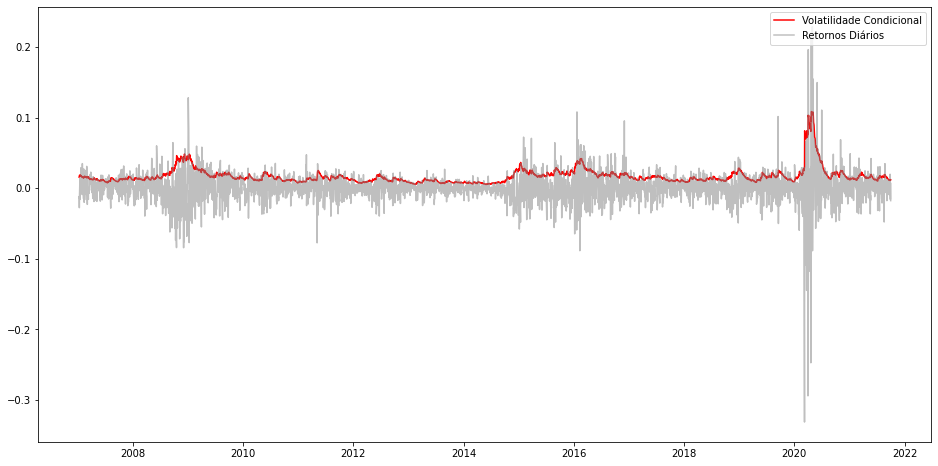

In [ ]:
# Visualização da volatilidade condicional e sua aderência à série de retono
plt.figure(figsize=(16, 8))
plt.plot(res.conditional_volatility, color = 'red', label = 'Volatilidade Condicional')
plt.plot(df['retorno'], color = 'grey', 
         label = 'Retornos Diários', alpha = 0.5)
plt.legend(loc = 'upper right')
plt.show()

##### Pré processamento de dados

A partir de agora, vamos organizar a base, normalizar e transformar em uma base supervisionada, onde teremos uma janela de 10 medidas para prever 3 medidas.

### Pre processamento dos dados

Aqui faremos todo o pré processamento e transformações necessárias para que o modelo se transforme em um imput para arede neural.

In [ ]:
# convertendo a base em supervisionada
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # imputando a sequência (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # seuquencia de forecast (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # colocando tudo junto
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop NAN´s
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# load dataset
dataset = df
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
reframed = series_to_supervised(dataset, 10, 3)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[50,51,52,53,55,56,57,58,60,61,62,63]], axis=1, inplace=True)
print(reframed.tail())

            var1(t-10)  var2(t-10)  var3(t-10)  ...   var5(t)  var5(t+1)  var5(t+2)
Date                                            ...                                
2021-09-23       71.82    0.009092    0.014173  ...  0.008873   0.008998   0.006078
2021-09-24       71.98    0.002225    0.013840  ...  0.008998   0.006078   0.004489
2021-09-27       72.77    0.010915    0.013223  ...  0.006078   0.004489   0.013578
2021-09-28       73.29    0.007120    0.013030  ...  0.004489   0.013578   0.013186
2021-09-29       73.78    0.006664    0.012679  ...  0.013578   0.013186   0.016436

[5 rows x 53 columns]


In [ ]:
#Colocando defasagens

# load dataset
dataset = df
# specify the number of lag hours
n_hours = 10
# frame as supervised learning
reframed = series_to_supervised(df, n_hours, 3) # 3 é o número de saída
reframed.drop(reframed.columns[[50,51,52,53,55,56,57,58,60,61,62,63]], axis=1, inplace=True) # removendo as variáveis que não são de interesse na previsão

# normalize features
values = reframed.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = pd.DataFrame(scaled)
reframed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
0,0.303323,0.567932,0.101276,0.604423,0.104041,0.298654,0.570443,0.105290,0.610947,0.104567,0.287915,0.542108,0.107710,0.553485,0.091404,0.283713,0.571794,0.125610,0.618479,0.068033,0.289005,0.616277,0.125998,0.700396,0.073361,0.282935,0.563048,0.122351,0.601367,0.074372,0.278188,0.568928,0.127569,0.613651,0.074488,0.280289,0.601524,0.129325,0.672914,0.063359,0.280756,0.593719,0.121896,0.658992,0.060765,0.291806,0.643255,0.113078,0.757517,0.088225,0.075725,0.071628,0.070991
1,0.298654,0.570443,0.105290,0.610947,0.104567,0.287915,0.542108,0.107710,0.553485,0.091404,0.283713,0.571794,0.125610,0.618479,0.068033,0.289005,0.616277,0.125998,0.700396,0.073361,0.282935,0.563048,0.122351,0.601367,0.074372,0.278188,0.568928,0.127569,0.613651,0.074488,0.280289,0.601524,0.129325,0.672914,0.063359,0.280756,0.593719,0.121896,0.658992,0.060765,0.291806,0.643255,0.113078,0.757517,0.088225,0.290872,0.587183,0.117014,0.646445,0.075725,0.071628,0.070991,0.077444
2,0.287915,0.542108,0.107710,0.553485,0.091404,0.283713,0.571794,0.125610,0.618479,0.068033,0.289005,0.616277,0.125998,0.700396,0.073361,0.282935,0.563048,0.122351,0.601367,0.074372,0.278188,0.568928,0.127569,0.613651,0.074488,0.280289,0.601524,0.129325,0.672914,0.063359,0.280756,0.593719,0.121896,0.658992,0.060765,0.291806,0.643255,0.113078,0.757517,0.088225,0.290872,0.587183,0.117014,0.646445,0.075725,0.301144,0.638413,0.110113,0.749620,0.071628,0.070991,0.077444,0.059067
3,0.283713,0.571794,0.125610,0.618479,0.068033,0.289005,0.616277,0.125998,0.700396,0.073361,0.282935,0.563048,0.122351,0.601367,0.074372,0.278188,0.568928,0.127569,0.613651,0.074488,0.280289,0.601524,0.129325,0.672914,0.063359,0.280756,0.593719,0.121896,0.658992,0.060765,0.291806,0.643255,0.113078,0.757517,0.088225,0.290872,0.587183,0.117014,0.646445,0.075725,0.301144,0.638413,0.110113,0.749620,0.071628,0.303867,0.603734,0.113010,0.679101,0.070991,0.077444,0.059067,0.066446
4,0.289005,0.616277,0.125998,0.700396,0.073361,0.282935,0.563048,0.122351,0.601367,0.074372,0.278188,0.568928,0.127569,0.613651,0.074488,0.280289,0.601524,0.129325,0.672914,0.063359,0.280756,0.593719,0.121896,0.658992,0.060765,0.291806,0.643255,0.113078,0.757517,0.088225,0.290872,0.587183,0.117014,0.646445,0.075725,0.301144,0.638413,0.110113,0.749620,0.071628,0.303867,0.603734,0.113010,0.679101,0.070991,0.302078,0.583468,0.107142,0.638276,0.077444,0.059067,0.066446,0.084201


In [ ]:
#definindo o número de features
n_features = 5

In [ ]:
# separando em treino e teste
values = reframed.values
n_train_hours = int(np.round(reframed.shape[0]*0.75))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# separando o imput e output
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print(train_X.shape, len(train_X), train_y.shape)
# reshape em 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2841, 50) 2841 (2841, 3)
(2841, 10, 5) (2841, 3) (947, 10, 5) (947, 3)


### Modelagem

In [ ]:
# Inicializar a RNN
regressor = Sequential()
 
# Adicionar a primeira camada GRU e Dropout 
regressor.add(GRU(units = 60, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
regressor.add(Dropout(0.35))
 
# Adicionar a segunda camada GRU e Dropout
#regressor.add(LSTM(units = 42, return_sequences = True))
#regressor.add(Dropout(0.25))
 
# Adicionar a terceira camada GRU e Dropout
regressor.add(GRU(units = 25))
#regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 3))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Visualizar a rede
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 10, 60)            12060     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 25)                6525      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 78        
Total params: 18,663
Trainable params: 18,663
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit network
history = regressor.fit(train_X, train_y, epochs=70, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/70
95/95 - 5s - loss: 0.0045 - accuracy: 0.3432 - val_loss: 0.0154 - val_accuracy: 0.3041
Epoch 2/70
95/95 - 1s - loss: 0.0027 - accuracy: 0.3464 - val_loss: 0.0107 - val_accuracy: 0.3094
Epoch 3/70
95/95 - 1s - loss: 0.0020 - accuracy: 0.3312 - val_loss: 0.0086 - val_accuracy: 0.2598
Epoch 4/70
95/95 - 1s - loss: 0.0014 - accuracy: 0.3333 - val_loss: 0.0074 - val_accuracy: 0.2788
Epoch 5/70
95/95 - 1s - loss: 0.0012 - accuracy: 0.3474 - val_loss: 0.0067 - val_accuracy: 0.2904
Epoch 6/70
95/95 - 1s - loss: 0.0010 - accuracy: 0.3548 - val_loss: 0.0061 - val_accuracy: 0.3347
Epoch 7/70
95/95 - 1s - loss: 9.5114e-04 - accuracy: 0.3661 - val_loss: 0.0058 - val_accuracy: 0.3611
Epoch 8/70
95/95 - 1s - loss: 9.2178e-04 - accuracy: 0.3615 - val_loss: 0.0057 - val_accuracy: 0.4456
Epoch 9/70
95/95 - 1s - loss: 8.8338e-04 - accuracy: 0.3847 - val_loss: 0.0055 - val_accuracy: 0.4150
Epoch 10/70
95/95 - 1s - loss: 8.6977e-04 - accuracy: 0.3812 - val_loss: 0.0054 - val_accuracy: 0.4382
Epo

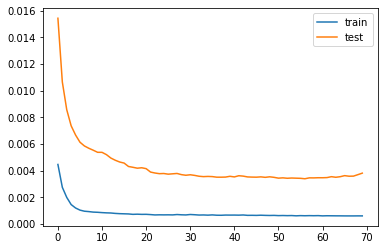

In [ ]:
# gráfico de histórico GRU
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# fazendo previsões
yhat = regressor.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invertendo a escala
inv_yhat = np.concatenate((test_X[:, -n_features*n_hours:], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, n_features*n_hours:]
# invertendo a escala y
test_y = test_y.reshape((len(test_y), 3))
inv_y = concatenate((test_X[:, -n_features*n_hours:], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, n_features*n_hours:]

### Métricas

In [ ]:
# RMSE para cada time step
rmse_all=[]
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = np.mean(np.abs((np.array(actual) - np.array(predicted))**2)**0.5)
		rmse_all.append(round(rmse,2))
		print('t+%d RMSE: %f' % ((i+1), rmse))
        
#evaluate forecasts
evaluation = evaluate_forecasts(inv_y, inv_yhat, n_hours, 3)

rmse_all 

t+1 RMSE: 0.004224
t+2 RMSE: 0.005520
t+3 RMSE: 0.006462


[0.0, 0.01, 0.01]

In [ ]:
# MSE para cada time step
mse_all=[]
def evaluate_forecasts(test, forecasts, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		mse = np.mean(np.abs((np.array(actual) - np.array(predicted))**2))
		mse_all.append(round(mse,2))
		print('t+%d MSE: %f' % ((i+1), mse))
        
#evaluate forecasts
evaluation = evaluate_forecasts(inv_y, inv_yhat, 3)

mse_all 

t+1 MSE: 0.000090
t+2 MSE: 0.000147
t+3 MSE: 0.000196


[0.0, 0.0, 0.0]

In [ ]:
# Mape para cada time step
mape_all=[]
def evaluate_forecasts_mape(test, forecasts, n_seq):
  for i in range(n_seq):
    actual = [row[i] for row in test]
    predicted = [forecast[i] for forecast in forecasts]
    #rmse = sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((np.array(actual) - np.array(predicted)) / np.array(actual)))*100
    mape_all.append(round(mape,2))
    print('t+%d MAPE: %f' % ((i+1), mape))
      
#evaluate forecasts
evaluation_mape = evaluate_forecasts_mape(inv_y, inv_yhat, 3)

t+1 MAPE: 25.273655
t+2 MAPE: 31.489059
t+3 MAPE: 36.514662


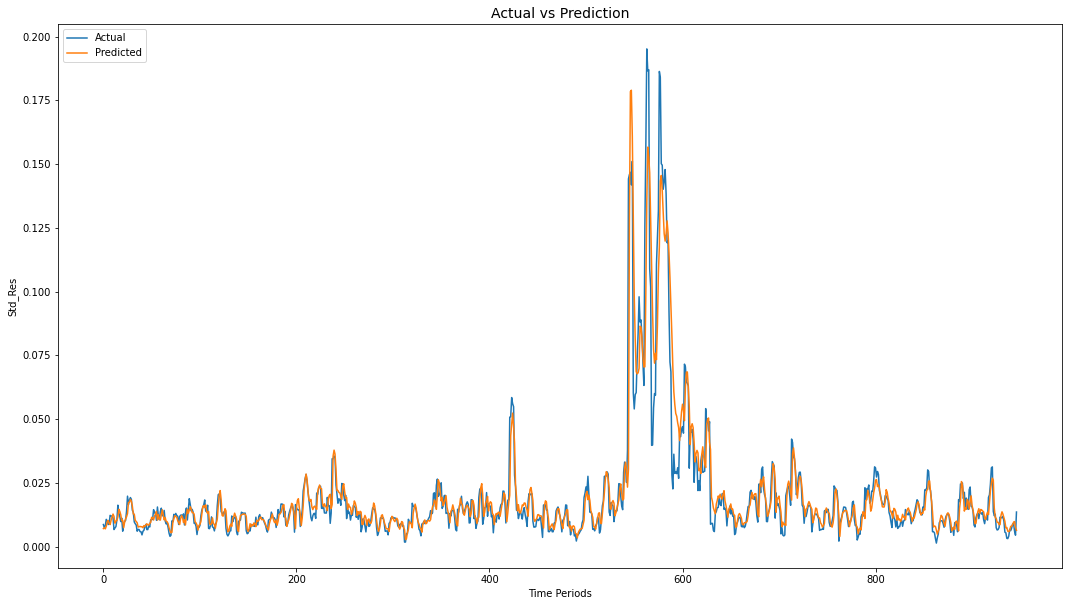

In [ ]:
# visualizando previsões e realidade
inv_yhat1 = inv_yhat[:,0]
inv_y1=inv_y[:,0]

#for i in range(10):
plt.figure(figsize=(18,10))
plt.title("Actual vs Prediction", fontsize=14)
plt.plot(inv_y1, label='Actual')
plt.plot(inv_yhat1, label='Predicted')
plt.legend(loc="upper left") 
plt.xlabel("Time Periods")
plt.ylabel(dataset.columns.values[3].title()) 
plt.show()

In [ ]:
# avaliação de gráfico da persistência

def plot_forecasts(series, forecasts, n_test):
  # plot the entire dataset in blue
  plt.plot(series,label="actual")
  # plot the forecasts in red
  for i in range(len(forecasts)):
    off_s = len(series) - inv_yhat.shape[0] + i - 1
    #off_e = off_s + len(forecasts[i]) + 1
    off_e = off_s + len(forecasts[i]) 
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = forecasts[i]
    plt.plot(xaxis, yaxis, color='red')
  plt.plot(xaxis, yaxis, color='red',label="prediction")        
  plt.subplots_adjust(left=0.07)
  plt.ylabel('Volatility Energy', size=15)
  plt.xlabel('Time Steps', size=15)
  plt.legend(fontsize=15)        
  # show the plot
  plt.show()  

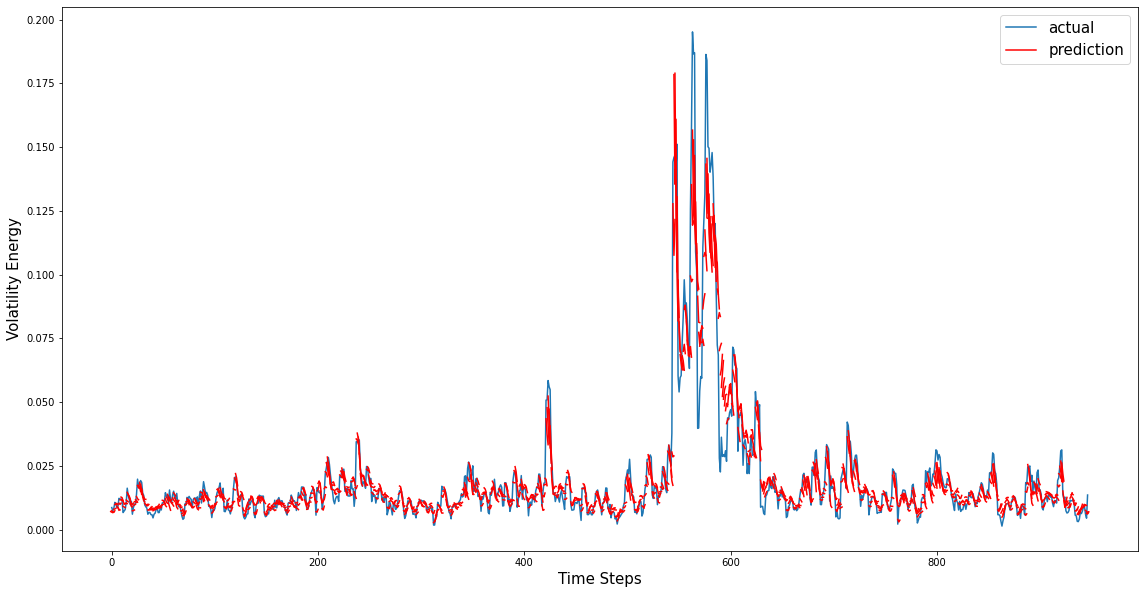

In [ ]:
# persistencia
series = inv_y[:,0]
forecasts = inv_yhat
n_test = inv_yhat.shape[0] 

# plot forecasts
plt.figure(figsize =(18, 10)) 
plot_forecasts(series, forecasts, n_test+2)

## Conclusão

Dada importância da mensuração da volatilidade, uma vez que é uma medida de risco, o modelo poderá gerar valor para qualquer instituição financeira que necessite de elevado gerenciamento de risco.

Mesmo que as métricas não tenham sido extremamente baixas como se é de costume verificar em séries temporais de preço, tenhamos em mente o nível de ruído previsto. Assim podemos avaliar, gráficamente, que as medidas encontradas foram muito boas. 

Também é interessante avaliar o gráfico de persistência, uma vez que agentes se posicionem em um período maior do que um dia. Assim verificamos que o modelo é aderente em indicações, captando picos e vales de maenira adequada.

